In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import decomposition, manifold, linear_model, model_selection, metrics, multioutput, svm, preprocessing
snsblue = sns.color_palette('pastel')[0]

In [2]:
md = pd.read_csv('metadata-pg-genres-subset.tsv', sep='\t', index_col='id')
md

,title,author,gender,year-birth,year-death,year-worldcat,year-ref,language,translation,downloads,...,Love,War,Humour,Sea,Pulp fiction,SciFi & Fantasy,General fiction,Mystery & Detective stories,Juvenile,Translations
id,,,,,,,,,,,,,,,,,,,,,
PG66248,"The Texas Hawks; or, The Strange Decoy","Badger, Jos. E. (Joseph Edward)",NaN,1848.0,1909.0,1871.0,1871,['en'],NaN,61,...,0,0,0,0,1,0,0,0,0,0
PG50246,Running to Waste: The Story of a Tomboy,"Baker, George M. (George Melville)",NaN,1832.0,1890.0,2007.0,1871,['en'],NaN,10,...,0,0,0,0,0,0,0,0,1,0
PG49170,Summer Days,"Baker, George M. (George Melville)",NaN,1832.0,1890.0,2007.0,1871,['en'],NaN,7,...,0,0,0,0,0,0,0,0,1,0
PG21740,The Iron Horse,"Ballantyne, R. M. (Robert Michael)",NaN,1825.0,1894.0,1871.0,1871,['en'],NaN,28,...,0,0,0,0,0,0,0,0,1,0
PG29623,The Cuckoo Clock,"Barefoot, Wesley",NaN,NaN,NaN,1871.0,1871,['en'],NaN,17,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PG59516,The Scamperers,"Stearns, Charles A.",NaN,NaN,NaN,2018.0,2018,['en'],NaN,11,...,0,0,0,0,0,1,0,0,0,0
PG61133,The Happy Homicide,"Banta, Frank",NaN,NaN,NaN,2019.0,2019,['en'],NaN,5,...,0,0,0,0,0,1,0,0,0,0
PG64314,Beyond the X Ecliptic,"Holden, Fox B.",NaN,1923.0,NaN,2019.0,2019,['en'],NaN,12,...,0,0,0,0,0,1,0,0,0,0


In [3]:
genres = ['Western', 'Adventure', 'Love', 'War', 'Humour', 'Sea',
                'Pulp fiction', 'SciFi & Fantasy', 'General fiction',
                'Mystery & Detective stories', 'Juvenile', 'Translations']
genredf = pd.DataFrame({'# texts': md.loc[:, genres].sum().sort_values(ascending=False)})
genredf

,# texts
General fiction,3470
SciFi & Fantasy,2578
Juvenile,1959
Adventure,968
Mystery & Detective stories,943
Love,574
Western,366
Translations,269
Humour,216
War,210


In [4]:
genredf.sum()

# texts    11887
dtype: int64

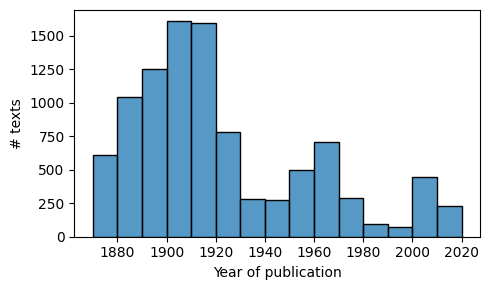

In [5]:
fig, ax = plt.subplots(figsize=(5, 3))
decades = range(md['year-ref'].min() // 10 * 10, md['year-ref'].max() // 10 * 10 + 1, 10)
sns.histplot(md['year-ref'], bins=decades, ax=ax);
ax.set_ylabel('# texts'); ax.set_xlabel('Year of publication');
ax.figure.tight_layout(); ax.figure.savefig('fig/fig5.2yearhist.pdf'); ax.figure.savefig('fig/fig5.2yearhist.png', dpi=150);

In [6]:
weightsperbook = pd.read_csv('doctopics_pertext.tsv.gz', sep='\t', index_col=0)
weightsperbook

,t0: madame monsieur mademoiselle,t1: sir master lord,t2: eyes face looked,t3: uncle boy wiggily,t4: men enemy fire,t5: ses ave wot,t6: dog rabbit time,t7: car train street,t8: house farm farmer,t9: fact eye person,...,t90: hand head feet,t91: boat water sea,t92: wilfrid beauchamp woman,t93: table eat water,t94: boys boy camp,t95: garden trees green,t96: angus laird scotland,t97: herrick brand carr,t98: face eyes death,t99: squire sir day
ID,,,,,,,,,,,,,,,,,,,,,
PG10002,0.000030,0.001331,0.026010,0.000799,0.000218,0.000015,0.009403,0.002292,0.000036,0.000795,...,0.072651,0.003736,0.000008,0.002898,0.004300,0.013728,0.000011,0.000008,0.030394,0.000011
PG10008,0.000030,0.000077,0.055917,0.000105,0.002505,0.000176,0.002584,0.000802,0.000036,0.043174,...,0.072016,0.032317,0.000089,0.011744,0.005965,0.001282,0.000373,0.000008,0.018056,0.000292
PG10027,0.000031,0.000199,0.019394,0.000276,0.015277,0.011502,0.005511,0.011781,0.000196,0.025624,...,0.052107,0.000355,0.000008,0.040586,0.036174,0.009408,0.000012,0.000008,0.003189,0.000012
PG10046,0.001092,0.173777,0.015615,0.001183,0.019380,0.000110,0.001301,0.000338,0.003156,0.006930,...,0.064296,0.003929,0.000040,0.014373,0.000696,0.035798,0.072929,0.000039,0.056602,0.000167
PG10048,0.000308,0.000384,0.087311,0.001020,0.000613,0.000159,0.005503,0.028604,0.002750,0.004934,...,0.022897,0.000829,0.000084,0.035065,0.073785,0.001685,0.000116,0.000079,0.009263,0.000117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PG9981,0.006782,0.000538,0.011059,0.017504,0.002008,0.000015,0.002173,0.023491,0.002073,0.063518,...,0.007150,0.004360,0.000083,0.030631,0.000621,0.011916,0.000036,0.000008,0.012091,0.000011
PG9986,0.000030,0.000037,0.027600,0.000024,0.000921,0.002373,0.005515,0.010521,0.000650,0.004292,...,0.010496,0.006427,0.000008,0.021545,0.002271,0.001547,0.000011,0.000008,0.030608,0.001147
PG9988,0.000037,0.000496,0.026635,0.000030,0.001122,0.000019,0.000785,0.004863,0.018258,0.062430,...,0.000427,0.000948,0.000121,0.034136,0.001164,0.006654,0.000014,0.000009,0.000511,0.000014


In [7]:
with open('topickeys.txt') as inp:
    data = inp.read()
topiclabels = pd.DataFrame([line.split(None, 2) for line in data.splitlines()],
            columns=['topic', 'proportion', 'words']).set_index('topic')
topiclabels['proportion'] = topiclabels.proportion.astype(float)
topiclabels['sixwords'] = [' '.join(a.split()[:6]) for a in topiclabels.words]
topiclabels['label'] = weightsperbook.columns
topiclabels

,proportion,words,sixwords,label
topic,,,,
0,0.02943,madame monsieur mademoiselle french english mo...,madame monsieur mademoiselle french english mon,t0: madame monsieur mademoiselle
1,0.03671,sir master lord set men mistress hand gentlema...,sir master lord set men mistress,t1: sir master lord
2,0.30041,eyes face looked hand voice turned girl head s...,eyes face looked hand voice turned,t2: eyes face looked
3,0.02395,uncle boy wiggily nephew gentleman house big p...,uncle boy wiggily nephew gentleman house,t3: uncle boy wiggily
4,0.05126,men enemy fire battle army fight attack time f...,men enemy fire battle army fight,t4: men enemy fire
...,...,...,...,...
95,0.11693,garden trees green tree house flowers white gr...,garden trees green tree house flowers,t95: garden trees green
96,0.01112,angus laird scotland lad weel day aye minister...,angus laird scotland lad weel day,t96: angus laird scotland
97,0.00757,herrick brand carr dickie wilkins wentworth ca...,herrick brand carr dickie wilkins wentworth,t97: herrick brand carr


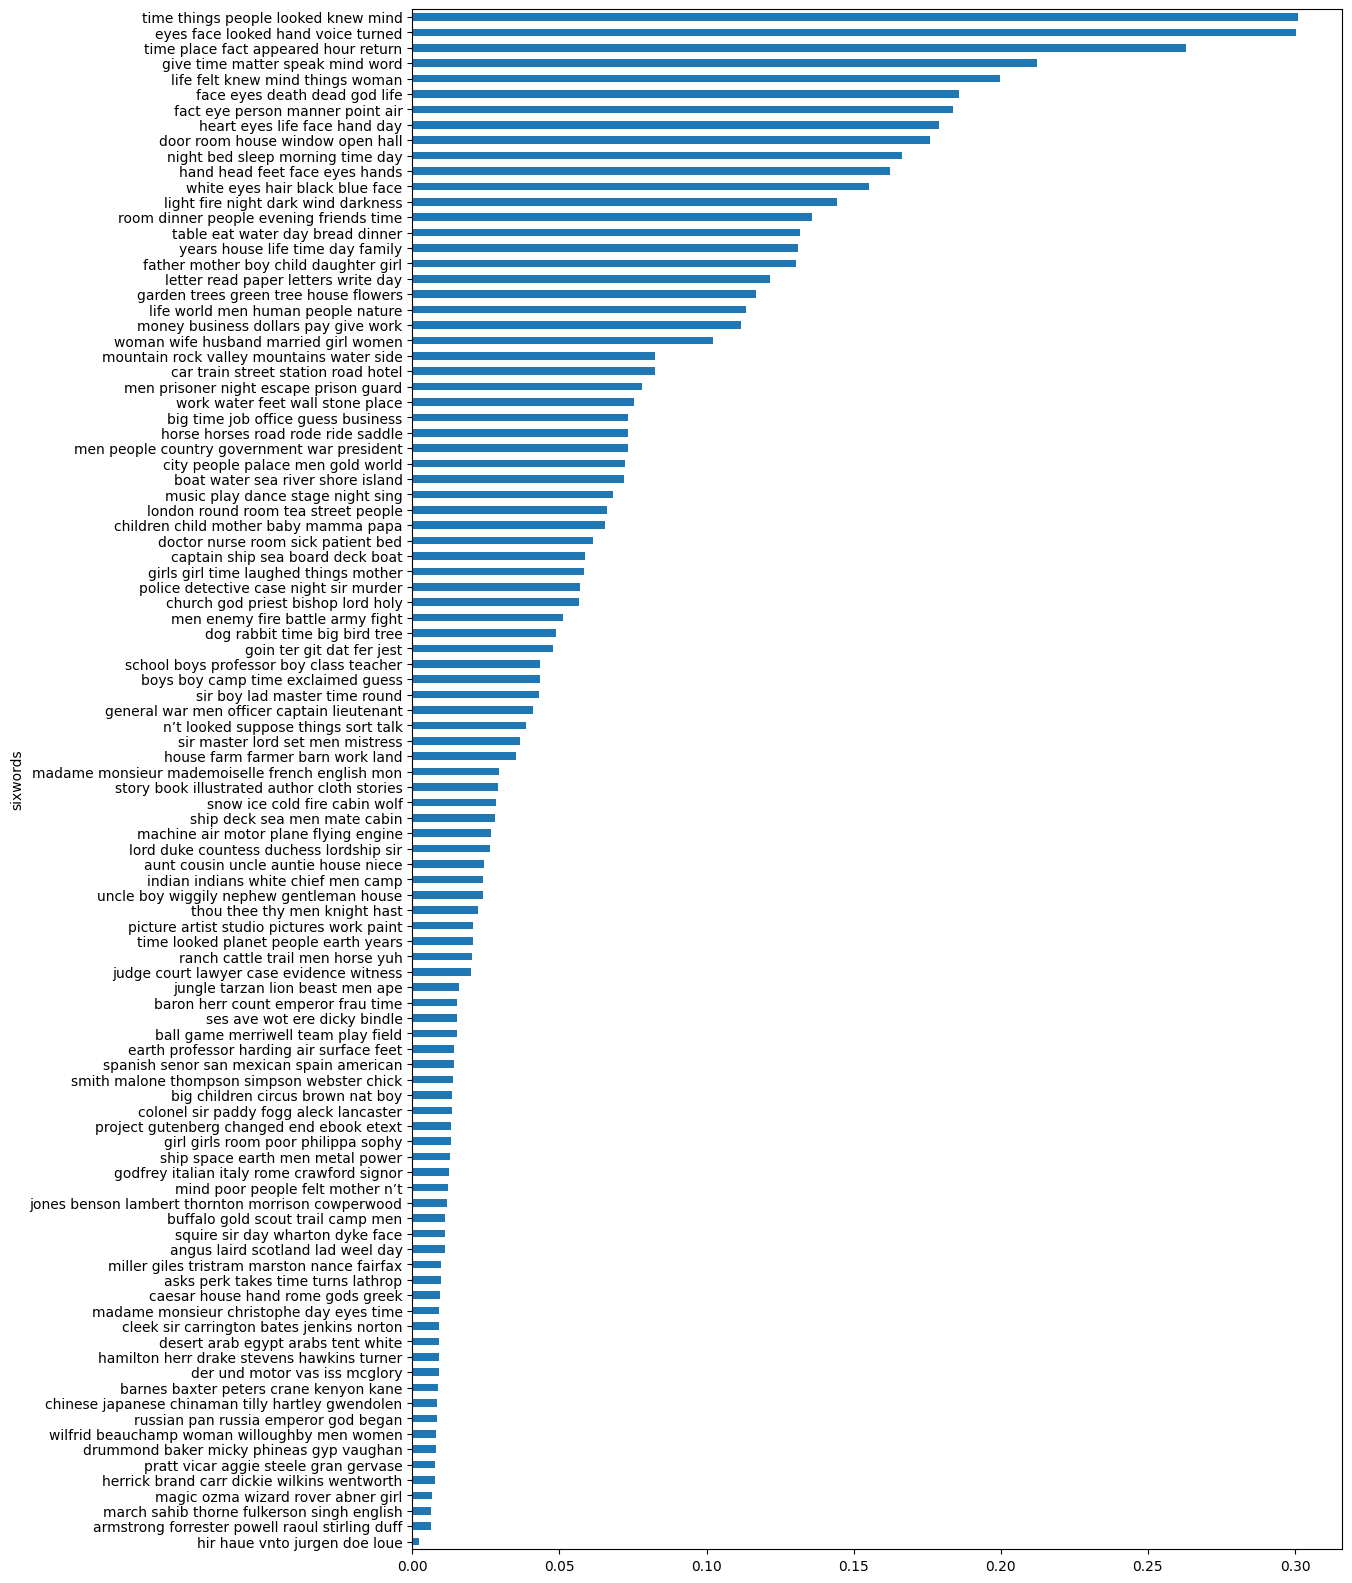

In [8]:
topiclabels.sort_values('proportion').set_index('sixwords').proportion.plot.barh(figsize=(12, 20));

In [9]:
df = pd.concat([md, weightsperbook], axis=1)
df

,title,author,gender,year-birth,year-death,year-worldcat,year-ref,language,translation,downloads,...,t90: hand head feet,t91: boat water sea,t92: wilfrid beauchamp woman,t93: table eat water,t94: boys boy camp,t95: garden trees green,t96: angus laird scotland,t97: herrick brand carr,t98: face eyes death,t99: squire sir day
PG66248,"The Texas Hawks; or, The Strange Decoy","Badger, Jos. E. (Joseph Edward)",NaN,1848.0,1909.0,1871.0,1871,['en'],NaN,61,...,0.072657,0.002126,0.000009,0.000154,0.006868,0.000221,0.000013,0.001128,0.096665,0.000013
PG50246,Running to Waste: The Story of a Tomboy,"Baker, George M. (George Melville)",NaN,1832.0,1890.0,2007.0,1871,['en'],NaN,10,...,0.048562,0.011994,0.000010,0.030896,0.000052,0.008248,0.000431,0.000009,0.007912,0.000067
PG49170,Summer Days,"Baker, George M. (George Melville)",NaN,1832.0,1890.0,2007.0,1871,['en'],NaN,7,...,0.003077,0.089823,0.000098,0.020083,0.001411,0.054009,0.006440,0.000092,0.002269,0.000136
PG21740,The Iron Horse,"Ballantyne, R. M. (Robert Michael)",NaN,1825.0,1894.0,1871.0,1871,['en'],NaN,28,...,0.026782,0.001329,0.000008,0.012873,0.001352,0.003900,0.000893,0.000008,0.019087,0.000012
PG29623,The Cuckoo Clock,"Barefoot, Wesley",NaN,NaN,NaN,1871.0,1871,['en'],NaN,17,...,0.001190,0.000074,0.000008,0.023675,0.001068,0.024683,0.000011,0.000008,0.019636,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PG59516,The Scamperers,"Stearns, Charles A.",NaN,NaN,NaN,2018.0,2018,['en'],NaN,11,...,0.040347,0.004170,0.000059,0.011929,0.006976,0.012807,0.000081,0.000055,0.024886,0.000082
PG61133,The Happy Homicide,"Banta, Frank",NaN,NaN,NaN,2019.0,2019,['en'],NaN,5,...,0.099551,0.000132,0.000015,0.000242,0.014784,0.000215,0.001858,0.000014,0.002180,0.000021
PG64314,Beyond the X Ecliptic,"Holden, Fox B.",NaN,1923.0,NaN,2019.0,2019,['en'],NaN,12,...,0.021928,0.000178,0.000020,0.002847,0.000108,0.002118,0.000028,0.000019,0.034855,0.000028
PG59575,Dearest Enemy,"Holden, Fox B.",NaN,1923.0,NaN,2020.0,2020,['en'],NaN,31,...,0.220054,0.000427,0.000048,0.008744,0.000259,0.005981,0.000066,0.000045,0.074619,0.000067


In [10]:
# one missing text
md.index.difference(weightsperbook.index)

Index(['PG61119'], dtype='object')

In [11]:
md.loc['PG61119', :]

title                                                           Dangerous Quarry
author                                                               Harmon, Jim
gender                                                                       NaN
year-birth                                                                1933.0
year-death                                                                2010.0
year-worldcat                                                             1994.0
year-ref                                                                    1994
language                                                                  ['en']
translation                                                                  NaN
downloads                                                                      8
subjects                       {'Cities and towns -- Fiction', 'Insurance adj...
shortauthor                                                           Jim+Harmon
shorttitle                  

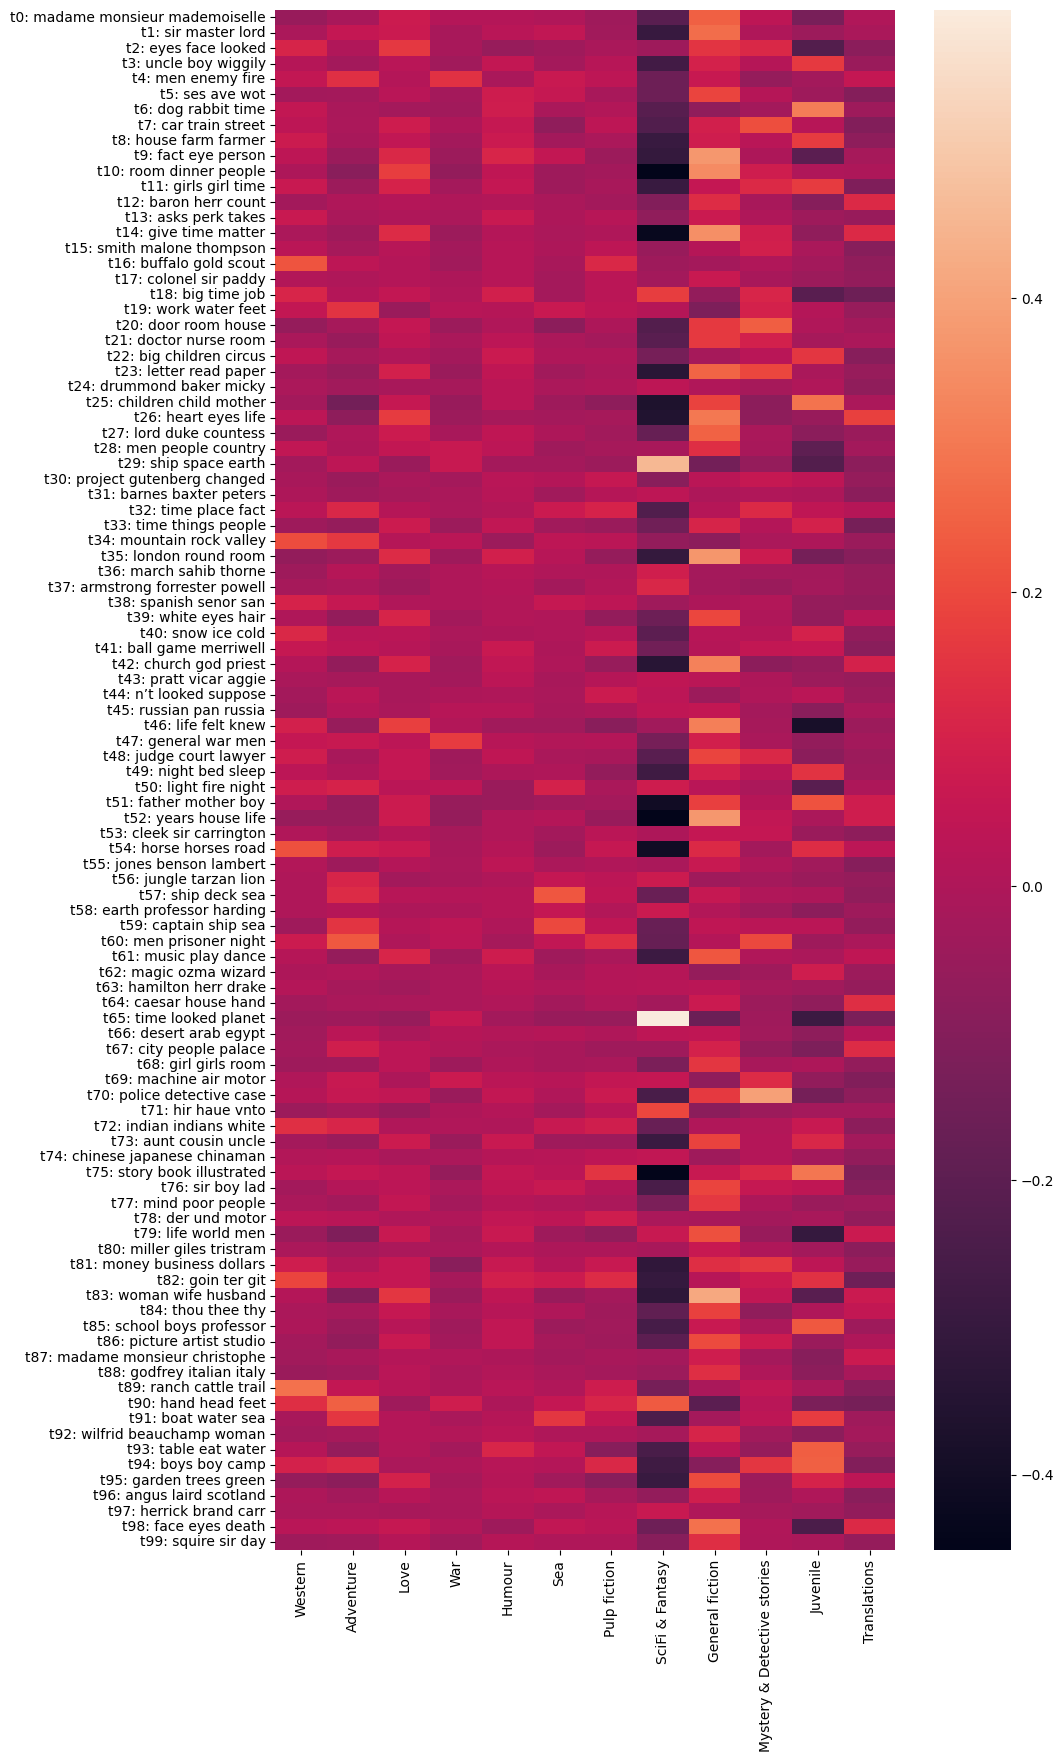

In [12]:
correlations = df.corr(method='spearman', numeric_only=True).loc[weightsperbook.columns, genres]
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(correlations, ax=ax);

In [13]:
for genre in genres:
    print(genre)
    print(correlations[genre].sort_values(ascending=False).head(5))
    print()


Western
t89: ranch cattle trail      0.283927
t16: buffalo gold scout      0.221114
t54: horse horses road       0.213382
t34: mountain rock valley    0.206848
t82: goin ter git            0.190944
Name: Western, dtype: float64

Adventure
t90: hand head feet          0.247657
t60: men prisoner night      0.229891
t34: mountain rock valley    0.158801
t91: boat water sea          0.157762
t59: captain ship sea        0.152064
Name: Adventure, dtype: float64

Love
t46: life felt knew        0.178187
t10: room dinner people    0.170760
t26: heart eyes life       0.169217
t2: eyes face looked       0.159849
t83: woman wife husband    0.157890
Name: Love, dtype: float64

War
t47: general war men      0.169069
t4: men enemy fire        0.145348
t90: hand head feet       0.081928
t69: machine air motor    0.072312
t29: ship space earth     0.062542
Name: War, dtype: float64

Humour
t9: fact eye person       0.112395
t93: table eat water      0.111551
t18: big time job         0.091156
t82: go

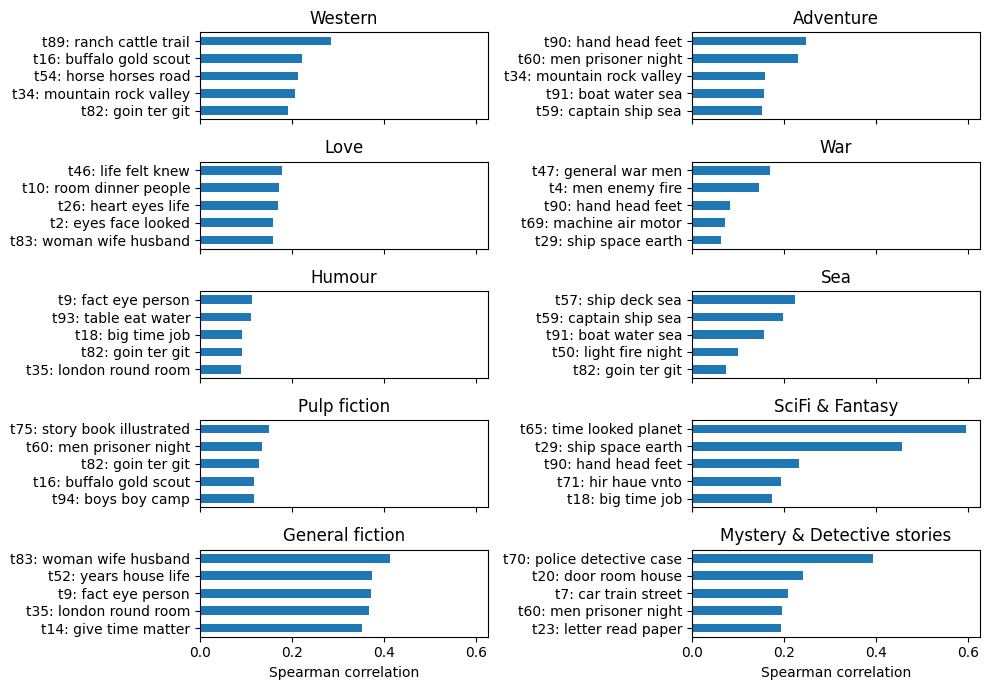

In [14]:
fig, axes = plt.subplots(5, 2, figsize=(10, 7), sharex=True)
for ax, genre in zip(axes.flatten(), genres):
    correlations[genre].sort_values(ascending=False).head(5)[::-1].plot.barh(ax=ax)
    ax.set_title(genre); ax.set_xlabel('Spearman correlation');
fig.tight_layout();
fig.savefig('fig/fig5.3top5corrs_genres.png', dpi=150); fig.savefig('fig/fig5.3top5corrs_genres.pdf')

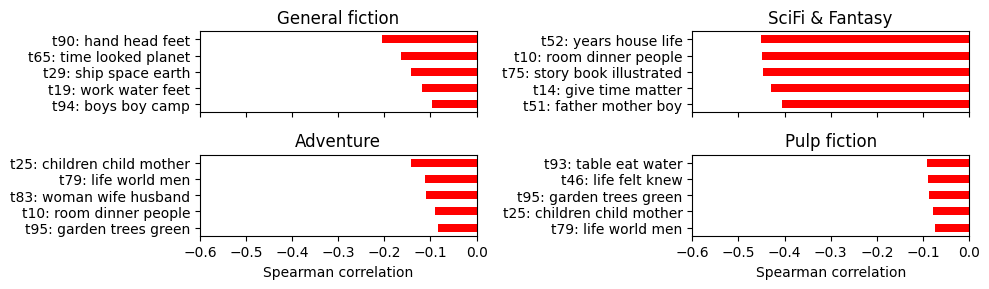

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 3), sharex=True)
neggenres = ['General fiction', 'SciFi & Fantasy', 'Adventure', 'Pulp fiction']
for ax, genre in zip(axes.flatten(), neggenres):
    correlations[genre].sort_values(ascending=False).tail(5).plot.barh(ax=ax, color='r')
    ax.set_title(genre)
    ax.set_xlabel('Spearman correlation')
    ax.set_xlim((-0.6, 0))
fig.tight_layout();
fig.savefig('fig/fig5.4bottom5corrs_genres.png', dpi=150); fig.savefig('fig/fig5.4bottom5corrs_genres.pdf')

In [16]:
def permute_col(perm_col, mean_col, data, iterations=50, seed=0):
    """Generate a DataFrame with means for `mean_col`, grouped by `perm_col`, which is randomly permuted."""
    np.random.seed(seed)
    df = data.loc[:, [perm_col, mean_col]].copy()
    result = []
    for _ in range(iterations):
        df[perm_col] = np.random.permutation(data[perm_col])
        result.extend(df.groupby(perm_col)[mean_col].mean().to_dict().items())
    return pd.DataFrame(result, columns=[perm_col, mean_col])

def permutation_plot(x, y, data, iterations=1000, ax=None):
    """Make a permutation plot given a DataFrame `data`, as in Jockers & Mimno (2013, Fig 4).

    :param x: the name of a column to group the data by (categorical).
    :param y: the name of a column to estimate the mean for (continuous);
    :param data: a DataFrame.
    """
    permuted = permute_col(x, y, df, iterations=iterations)
    ax = sns.pointplot(x=x, y=y, data=df, join=False, errorbar=None, color='red', ax=ax)
    ax = sns.stripplot(x=x, y=y, data=permuted, color='gray', alpha=0.25, ax=ax)
    ax.set_title('Permutation plot')
    ax.set_ylabel('mean')
    return ax

def bootstrap_plot(x, y, data, iterations=1000, ax=None):
    ax = sns.pointplot(x=x, y=y, data=data, join=False, n_boot=iterations, ax=ax)
    ax.set_title('Bootstrap plot')
    ax.set_ylabel('mean')
    return ax

def both_plots(x, y, data, fname, figsize=(8, 4)):
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True, sharex=True)
    permutation_plot(x, y, data, ax=axes[0])
    bootstrap_plot(x, y, data, ax=axes[1])
    fig.suptitle(y)  #, y=1.05)
    fig.tight_layout()
    fig.savefig(f'fig/{fname}.png', dpi=150)
    fig.savefig(f'fig/{fname}.pdf')
    return fig

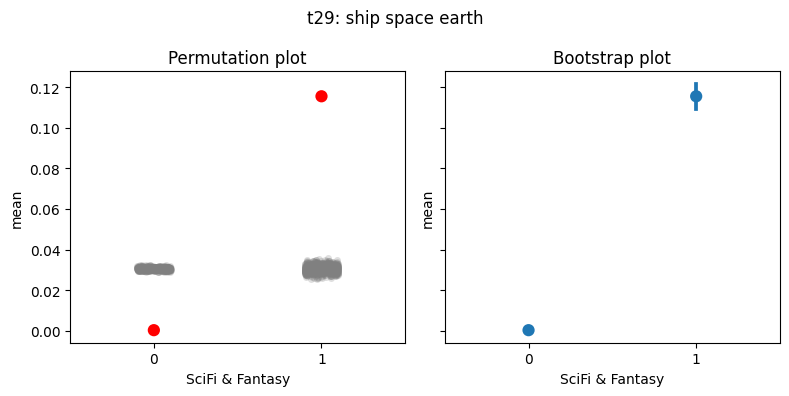

In [17]:
fig = both_plots('SciFi & Fantasy', 't29: ship space earth', df, 'fig5.5_t29_scifi')

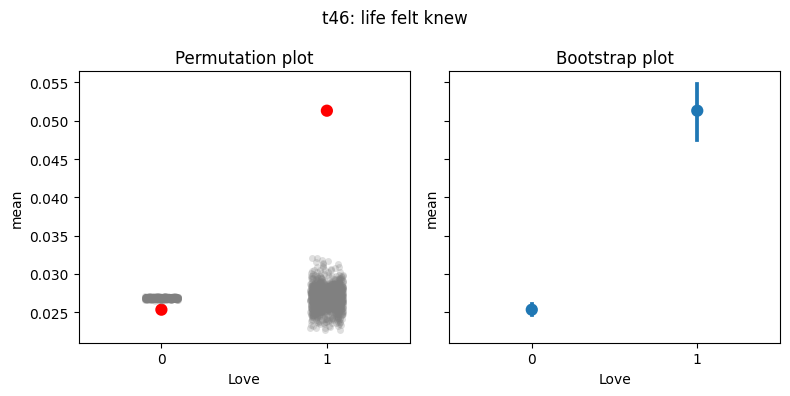

In [18]:
fig = both_plots('Love', 't46: life felt knew', df, 'fig5.6_t46_love')

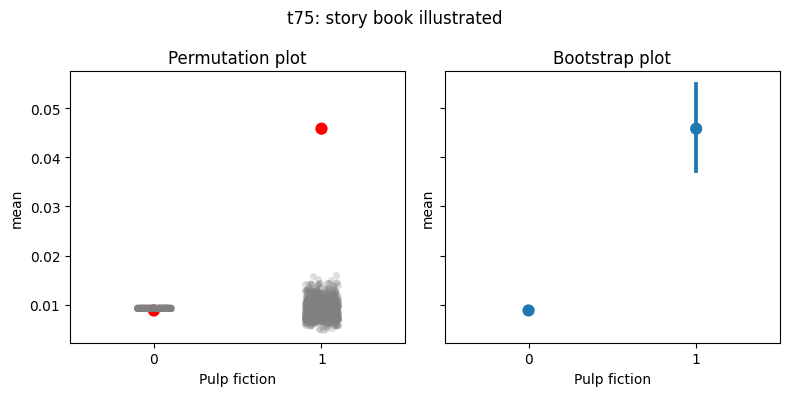

In [19]:
fig = both_plots('Pulp fiction', 't75: story book illustrated', df, 'fig_t75_pulp')

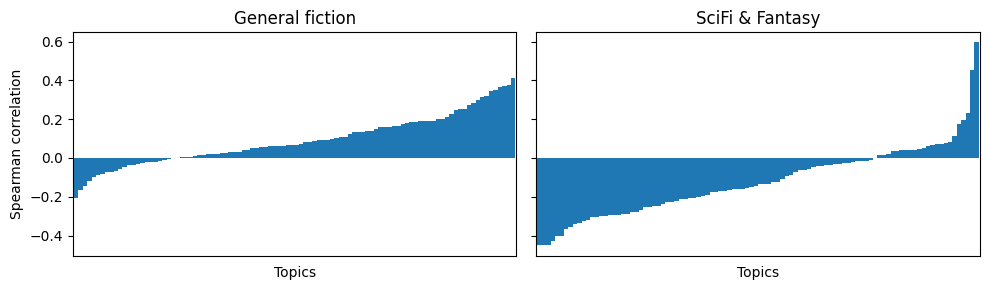

In [20]:
# by correlations
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for ax, genre in zip(axes.flatten(), ['General fiction', 'SciFi & Fantasy']):
    correlations[genre].sort_values(ascending=False).reset_index(drop=True).head(100)[::-1].plot.bar(ax=ax, width=1)
    ax.set_title(genre); ax.set_ylabel('Spearman correlation'); ax.set_xlabel('Topics')
    ax.get_xaxis().set_ticks([])
fig.tight_layout()
fig.savefig('fig/fig5.7corrs_genfic_scifi.png', dpi=150); fig.savefig('fig/fig5.7corrs_genfic_scifi.pdf')

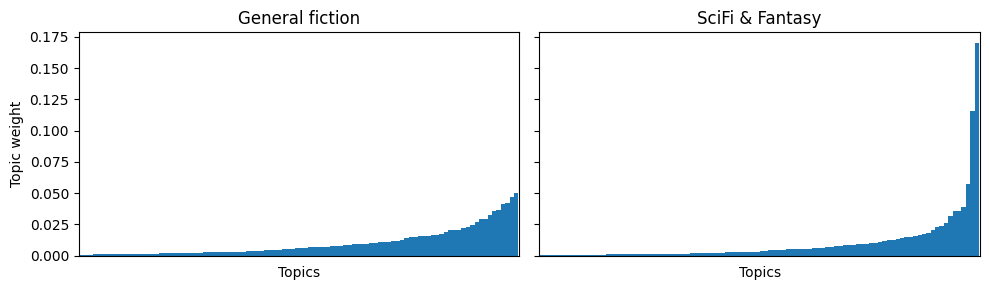

In [21]:
# by topic weights
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
for ax, genre in zip(axes.flatten(), ['General fiction', 'SciFi & Fantasy']):
    df.loc[df[genre] == 1, df.columns.str.match('^t[0-9]+:')].mean().sort_values().plot.bar(ax=ax, width=1)
    ax.set_title(genre); ax.set_ylabel('Topic weight'); ax.set_xlabel('Topics')
    ax.get_xaxis().set_ticks([])
fig.tight_layout()
# fig.savefig('fig/weights_genfic_scifi.png', dpi=150); fig.savefig('fig/weights_genfic_scifi.pdf')

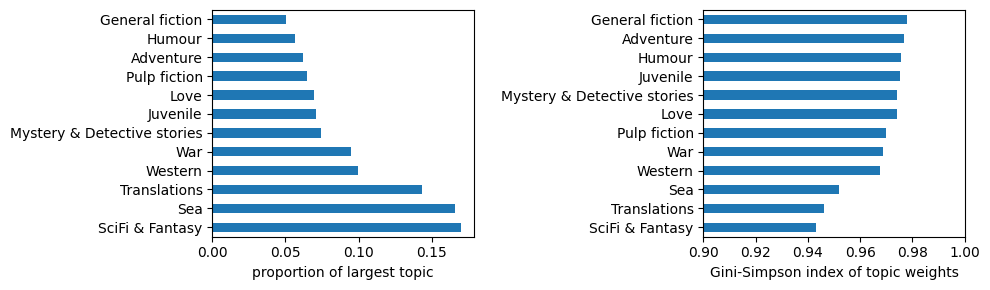

In [22]:
# Based on: https://gist.github.com/martinjc/f227b447791df8c90568
def get_gini_sampson_index(data):
    """ Given a hash { 'species': count } , returns the Gini-Simpson index
    
    >>> get_gini_sampson_index({'a': 10, 'b': 20, 'c': 30,})
    0.6111111111111112
    """
    def p(n, N):
        """Relative abundance."""
        return 0 if n == 0 else (n / N)

    N = sum(data.values())
    return 1 - sum(p(n, N)**2 for n in data.values() if n != 0)

# Plot average monotopicality per genre
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
maxtopic = pd.Series([df.loc[df[genre] == 1, df.columns.str.match('t[0-9]+')].mean().max()
        for genre in genres],
    index=genres)
maxtopic.sort_values(ascending=False).plot.barh(ax=ax1);
ax1.set_xlabel('proportion of largest topic');

ginisimpson_index = pd.Series([get_gini_sampson_index(dict(df.loc[df[genre] == 1, df.columns.str.match('t[0-9]+')].mean()))
        for genre in genres], index=genres)
ginisimpson_index.sort_values().plot.barh(ax=ax2);
ax2.set_xlabel('Gini-Simpson index of topic weights'); ax2.set_xlim(0.9, 1.0);
fig.tight_layout()
#fig.savefig('fig/fig5.8monotopicality.png', dpi=150); fig.savefig('fig/fig5.8monotopicality.pdf');

In [23]:
# Create a new version of the dataframe with one row for each instance of (ID, genre_label).
# This means that texts with multiple genre labels are represented as multiple rows in this dataframe!
concatted = pd.concat([df.loc[df[genre] == 1, :] for genre in genres], axis=0)
concatted.insert(
        0, 'genre',
        [genre
            for genre in genres
                for instance in range(df[genre].sum())])
concatted

,genre,title,author,gender,year-birth,year-death,year-worldcat,year-ref,language,translation,...,t90: hand head feet,t91: boat water sea,t92: wilfrid beauchamp woman,t93: table eat water,t94: boys boy camp,t95: garden trees green,t96: angus laird scotland,t97: herrick brand carr,t98: face eyes death,t99: squire sir day
PG2597,Western,Mrs. Skagg's Husbands and Other Stories,"Harte, Bret",NaN,1836.0,1902.0,1872.0,1872,['en'],NaN,...,0.026571,0.015484,0.000016,0.006237,0.000525,0.017956,0.000022,0.000015,0.030592,0.003043
PG65528,Western,"The Island Trapper; or, The Young White-Buffal...","Harbaugh, T. C. (Thomas Chalmers)",NaN,1849.0,1924.0,1873.0,1873,['en'],NaN,...,0.057549,0.007579,0.000009,0.000312,0.008508,0.000672,0.000013,0.000009,0.087116,0.000013
PG42619,Western,"Buckskin Mose: Or, Life From the Lakes to the ...","Perrie, George W.",NaN,NaN,NaN,1873.0,1873,['en'],NaN,...,0.045832,0.003102,0.001078,0.011753,0.006887,0.000600,0.000011,0.000192,0.033256,0.000492
PG51792,Western,A Debt of Honor: The Story of Gerald Lane's Su...,"Alger, Horatio, Jr.",NaN,1832.0,1899.0,1905.0,1876,['en'],NaN,...,0.027250,0.002823,0.000011,0.013423,0.010593,0.000936,0.000016,0.038907,0.009129,0.000567
PG36336,Western,Gabriel Conroy,"Harte, Bret",NaN,1836.0,1902.0,1876.0,1876,['en'],NaN,...,0.011551,0.003318,0.000105,0.006130,0.001054,0.005520,0.000263,0.000008,0.038069,0.001914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PG2047,Translations,The Lock and Key Library: the Most Interesting...,NaN,NaN,NaN,NaN,2011.0,2011,['en'],NaN,...,0.010728,0.001140,0.000123,0.006357,0.000047,0.013943,0.000012,0.000008,0.101118,0.000012
PG34840,Translations,"The Palace of Pleasure, Volume 3",NaN,NaN,NaN,NaN,2012.0,2012,['en'],NaN,...,0.001285,0.000709,0.000151,0.002681,0.000317,0.001920,0.000011,0.000125,0.005704,0.000011
PG34053,Translations,"The Palace of Pleasure, Volume 2",NaN,NaN,NaN,NaN,2012.0,2012,['en'],NaN,...,0.000997,0.000299,0.000008,0.002280,0.000101,0.001148,0.000011,0.000022,0.003407,0.000026
PG20241,Translations,"The Palace of Pleasure, Volume 1",NaN,NaN,NaN,NaN,2012.0,2012,['en'],NaN,...,0.000712,0.000693,0.000401,0.000643,0.000077,0.001278,0.000012,0.000008,0.002103,0.000026


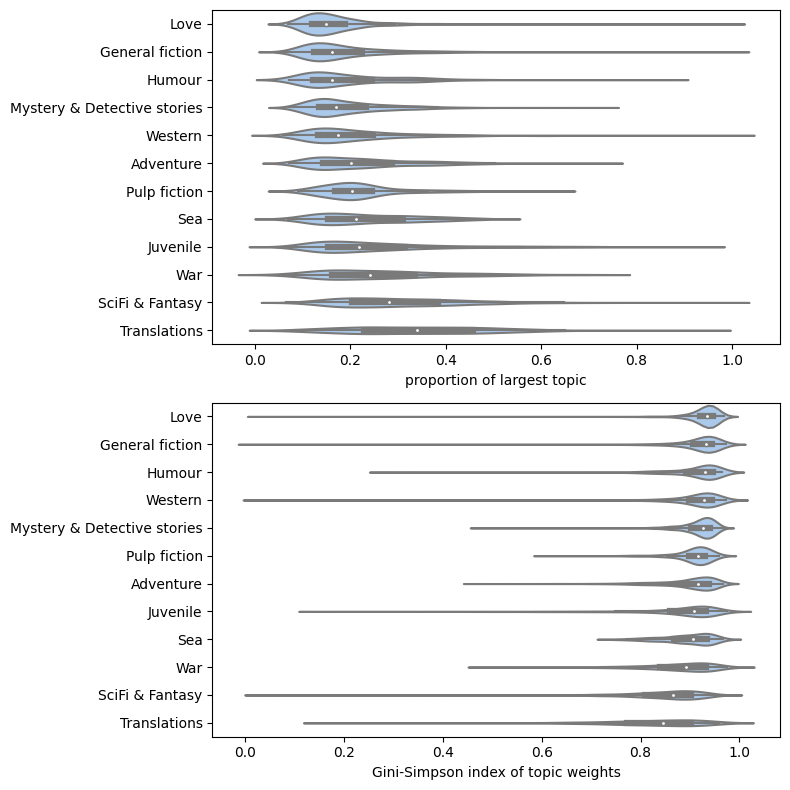

In [24]:
# Violinplots of monotopicality by genre
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

concatted['maxtopic'] = concatted.loc[:, concatted.columns.str.match('t[0-9]+')].max(axis=1)
sns.violinplot(data=concatted, x='maxtopic', y='genre', orient='horiz', color=snsblue, ax=ax1,
               order=concatted.groupby('genre')['maxtopic'].median().sort_values().index);
ax1.set_ylabel(None); ax1.set_xlabel('proportion of largest topic');

concatted['ginisimpson_index'] = concatted.loc[:, concatted.columns.str.match('t[0-9]+')].apply(
            lambda row: get_gini_sampson_index(dict(row)), axis=1)
sns.violinplot(data=concatted, x='ginisimpson_index', y='genre', orient='horiz', color=snsblue, ax=ax2,
               order=concatted.groupby('genre')['ginisimpson_index'].median().sort_values(ascending=False).index);
ax2.set_ylabel(None); ax2.set_xlabel('Gini-Simpson index of topic weights'); # ax2.set_xlim(0.9, 1.0);
#ax.set_yticklabels(order.index);
fig.tight_layout();
fig.savefig('fig/fig5.8monotopicality.png', dpi=150); fig.savefig('fig/fig5.8monotopicality.pdf');

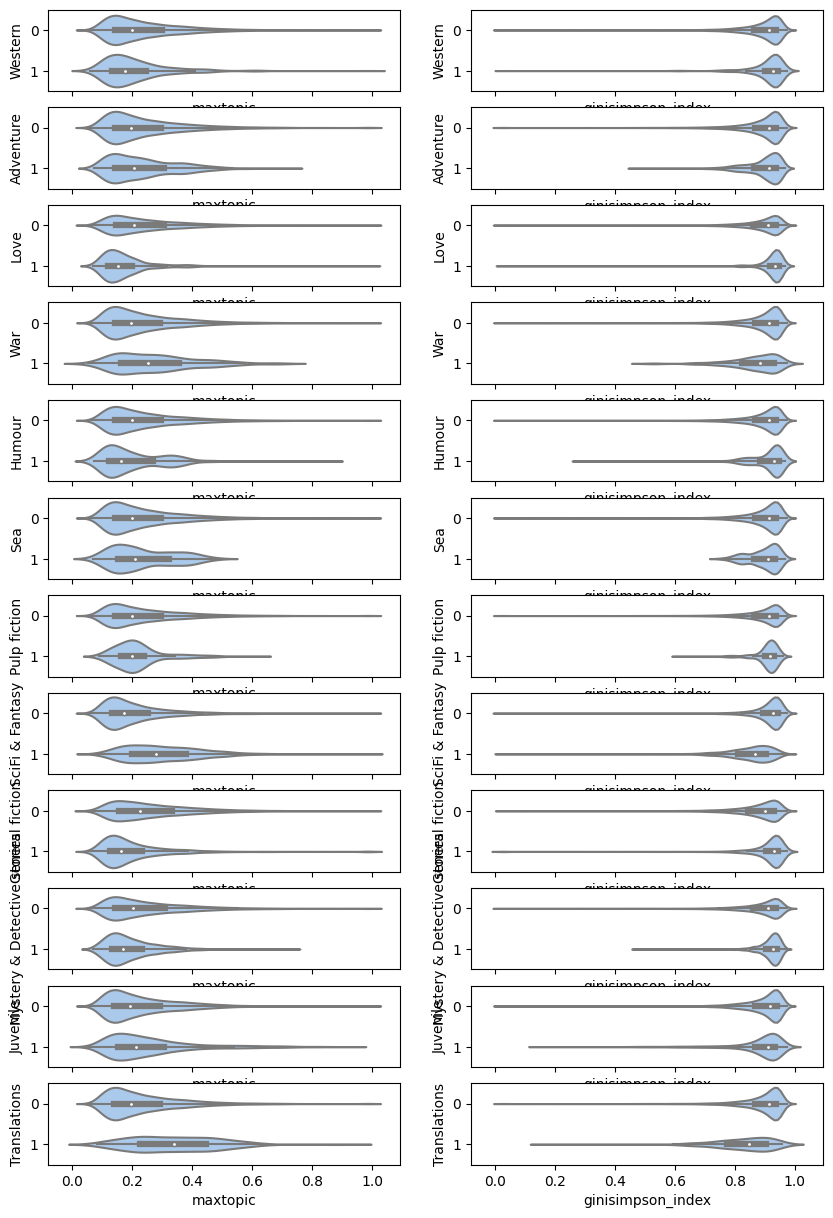

In [25]:
fig, axes = plt.subplots(len(genres), 2, figsize=(10, 15), sharex=True)
for n, genre in enumerate(genres):
    sns.violinplot(data=concatted, x='maxtopic', y=genre, orient='horiz', color=snsblue, ax=axes[n, 0]);
    sns.violinplot(data=concatted, x='ginisimpson_index', y=genre, orient='horiz', color=snsblue, ax=axes[n, 1]);